In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from simulai.regression import DenseNetwork
from simulai.optimization import Optimizer
from simulai.residuals import SymbolicOperator
from simulai.file import SPFile

#### Our PDE:
#### Allen-Cahn equation.

In [3]:
f = 'D(u, t) - mu*D(D(u, x), x) + alpha*(u**3) + beta*u'

g_u = 'u'
g_ux = 'D(u, x)'

input_labels = ['x', 't']
output_labels = ['u']

#### Domain dimensions.

In [4]:
X_DIM = 256
T_DIM = 100

L = 1
x_0 = -1
T = 1

#### Hyper-parameters.

In [5]:
n_epochs = 100_000
lr = 1e-3

#### Generating the training grid.

In [6]:
x_interval = [x_0, L]
t_interval = [0, T]

intervals = [x_interval, t_interval]

intv_array = np.vstack(intervals).T

# Regular grid
x_0, x_L = x_interval
t_0, t_L = t_interval
dx = (x_L - x_0) / X_DIM
dt = (t_L - t_0) / T_DIM

grid = np.mgrid[t_0+dt:t_L+dt:dt, x_0:x_L:dx]

data = np.hstack([grid[1].flatten()[:, None],
                  grid[0].flatten()[:, None]])

data_init = np.linspace(*x_interval, X_DIM)
u_init = ((data_init**2)*np.cos(np.pi * data_init))[:, None]

# Boundary grids
data_boundary_x0 = np.hstack([x_interval[0] * np.ones((T_DIM, 1)),
                              np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_xL = np.hstack([x_interval[-1] * np.ones((T_DIM, 1)),
                              np.linspace(*t_interval, T_DIM)[:, None]])

data_boundary_t0 = np.hstack([np.linspace(*x_interval, X_DIM)[:, None],
                              t_interval[0] * np.ones((X_DIM, 1))])

#### Model template.

In [7]:
def model():

    from simulai.models import ImprovedDenseNetwork
    from simulai.regression import SLFNN, ConvexDenseNetwork

    n_inputs = len(input_labels)
    n_outputs = len(output_labels)
    
    # Configuration for the fully-connected network
    config = {
        "layers_units": 6*[128],
        "activations": "tanh",
        "input_size": n_inputs,
        "output_size": n_outputs,
        "name": "net",
    }

    # Instantiating and training the surrogate model
    densenet = ConvexDenseNetwork(**config)
    encoder_u = SLFNN(input_size=n_inputs, output_size=128, activation="tanh")
    encoder_v = SLFNN(input_size=n_inputs, output_size=128, activation="tanh")

    net = ImprovedDenseNetwork(
        network=densenet,
        encoder_u=encoder_u,
        encoder_v=encoder_v,
        devices="gpu",
    )

    return net

#### Intantiating neural net.

In [8]:
net = model()
net.summary()

ImprovedDenseNetwork(
  (network): ConvexDenseNetwork(
    (net_input): Linear(in_features=2, out_features=128, bias=True)
    (net_0): Linear(in_features=128, out_features=128, bias=True)
    (net_1): Linear(in_features=128, out_features=128, bias=True)
    (net_2): Linear(in_features=128, out_features=128, bias=True)
    (net_3): Linear(in_features=128, out_features=128, bias=True)
    (net_4): Linear(in_features=128, out_features=128, bias=True)
    (net_5): Linear(in_features=128, out_features=1, bias=True)
  )
  (encoder_u): SLFNN(
    (nnet_linear_op): Linear(in_features=2, out_features=128, bias=True)
    (activation): Tanh()
  )
  (encoder_v): SLFNN(
    (nnet_linear_op): Linear(in_features=2, out_features=128, bias=True)
    (activation): Tanh()
  )
)


#### Constructor for the PINN symbolic residual.

In [9]:
residual = SymbolicOperator(expressions=[f],
                            input_vars=input_labels,
                            auxiliary_expressions={'periodic_u': g_u,
                                                   'periodic_du': g_ux},
                            constants={'mu':1e-4,
                                       'alpha':5,
                                       'beta':-5},
                            output_vars=output_labels,
                            function=net,
                            engine='torch',
                            device='gpu')

Using GPU.


#### Configuring optimizer.

In [10]:
optimizer_config = {'lr': lr}

optimizer = Optimizer('adam', params=optimizer_config,
                      lr_decay_scheduler_params={'name': 'ExponentialLR',
                                                         'gamma': 0.9,
                                                         'decay_frequency': 5_000},
                      shuffle=False,
                      summary_writer=True)

Optimizer adam found in torch.optim.


#### Information to be sent to the loss function.

In [11]:
params = {'residual': residual,
          'initial_input': data_boundary_t0,
          'initial_state': u_init,
          'boundary_input': {'periodic_u': [data_boundary_xL, data_boundary_x0],
                             'periodic_du': [data_boundary_xL, data_boundary_x0]},
          'boundary_penalties': [1, 1],
          'initial_penalty': 100}

#### Executing training.

In [12]:
optimizer.fit(op=net, input_data=data,
              n_epochs=n_epochs, loss="pirmse",
              params=params, device='gpu')

There are extra trainable parameters.
Using GPU.
Using LR decay <class 'torch.optim.lr_scheduler.ExponentialLR'>.
Data transferred to GPU.
pde:1.885158235381823e-05 init:8.911292752600275e-07 bound:4.821449692826718e-05  5 

#### Saving trained model.

In [13]:
saver = SPFile(compact=False)
saver.write(save_dir='.', name='allen_cahn_net', model=net, template=model)

#### Generating results using the trained model.

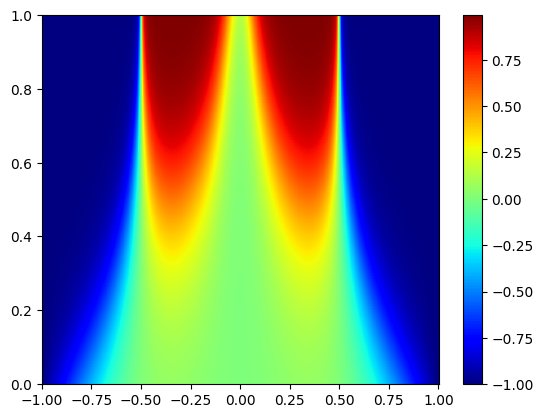

In [17]:
import torch 

# Evaluation and post-processing
X_DIM_F = 5 * X_DIM
T_DIM_F = 5 * T_DIM

x_f = np.linspace(*x_interval, X_DIM_F)
t_f = np.linspace(*t_interval, T_DIM_F)

T_f, X_f = np.meshgrid(t_f, x_f, indexing='ij')

data_f = np.hstack([X_f.flatten()[:, None],
                    T_f.flatten()[:, None]])

# Evaluation in training dataset
approximated_data = net.eval(input_data=torch.from_numpy(data_f.astype("float32")))

U_f = approximated_data.reshape(T_DIM_F, X_DIM_F)

fig, ax = plt.subplots()
ax.set_aspect('auto')
gf = ax.pcolormesh(X_f, T_f, U_f, cmap='jet')
fig.colorbar(gf);
plt.savefig('allen_cahn.png')
plt.show()

Text(0, 0.5, 'u')

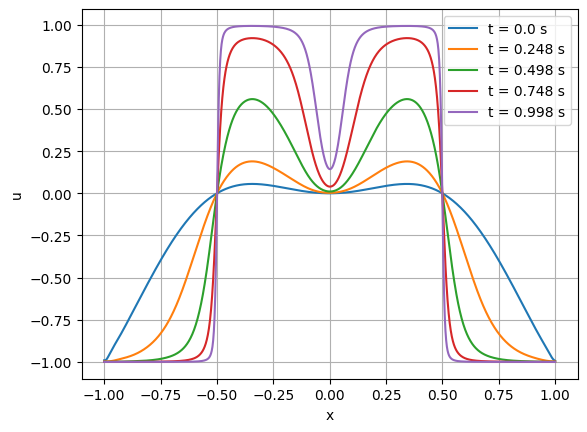

In [18]:
n_steps = T_DIM_F
steps_to_plot = np.linspace(0, n_steps-1, 5).astype(int).tolist()

for ss in steps_to_plot:
    plt.plot(x_f, U_f[ss, :], label=f"t = {round(ss/n_steps, 3)} s")

plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')

In [ ]:
#### A look in the boundaries

(-1.0, -0.98)

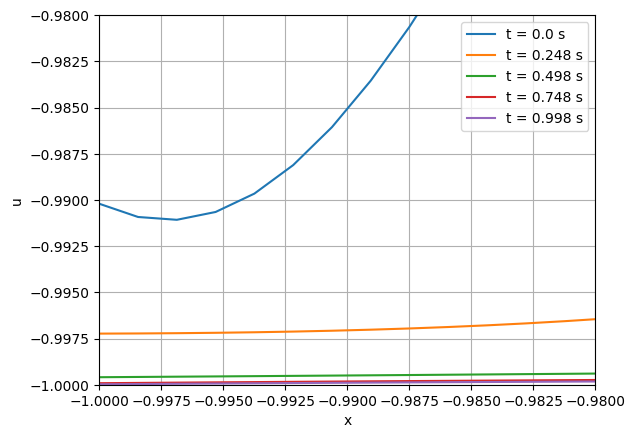

In [ ]:
n_steps = T_DIM_F
steps_to_plot = np.linspace(0, n_steps-1, 5).astype(int).tolist()

for ss in steps_to_plot:
    plt.plot(x_f, U_f[ss, :], label=f"t = {round(ss/n_steps, 3)} s")

plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.xlim(-1, -0.980)
plt.ylim(-1, -0.980)

In [ ]:
n_steps = T_DIM_F
steps_to_plot = np.linspace(0, n_steps-1, 5).astype(int).tolist()

for ss in steps_to_plot:
    plt.plot(x_f, U_f[ss, :], label=f"t = {round(ss/n_steps, 3)} s")

plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.xlim(-1, -0.980)
plt.ylim(-1, -0.980)

(-1.0, -0.98)